# Use overture to load key POIs for a given city
## POI types required
1. Bank
2. Retail
3. Tourism attraction
4. Amusement park or large theme park
## Data format required
1. latitude
2. longitude
3. overture ID
4. place_type
5. place_name (if available)
## Data accessing
* input: `city_name, province/state, country` or `polygon`
* output: a table of POI and their associated data based on the data format required described above
## Agent instruction
* No need to read through the repository. This is a stand alone python script. Use Python, duckdb, leafmap or any python package that are useful

In [ ]:
# load polygon from file
import geopandas as gpd
from overturemaps import core
import os

EXPORT_FOLDER = (
    "/Users/yuan/Dropbox (Personal)/Personal Work/_commondata/POI/overtunemaps/raw"
)
SHAPE_FOLDER = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was/_data/_raw/r_boundary_osm"
city_name = "Hong Kong"
# Example 1: Fetch POIs by city name
print("=" * 50)
print(f"Example 1: Fetching POIs for {city_name}")
print("=" * 50)

Example 1: Fetching POIs for Hong Kong


In [ ]:
city_lower = city_name.lower().replace(" ", "")

boundary_gdf = gpd.read_file(f"{SHAPE_FOLDER}/{city_lower}.geojson")
bbox = boundary_gdf.total_bounds  # (minx, miny, maxx, maxy)
places_df = core.geodataframe("place", bbox=(bbox[0], bbox[1], bbox[2], bbox[3]))
print(places_df.head())
print("Total records:", len(places_df))
places_df["top_category"] = places_df["categories"].apply(
    lambda x: x["primary"] if isinstance(x, dict) and "primary" in x else "unknown"
)
filtered_df = places_df[
    places_df["top_category"].str.contains(
        "bank|retail|tour|amusement|recreation|souvenir|cultural_center|museum|gallery",
        case=False,
        na=False,
    )
]

In [ ]:
# Full control over the output

places_df.to_parquet(
    path=os.path.join(EXPORT_FOLDER, f"{city_lower}.parquet"),
    engine="pyarrow",  # or "fastparquet"
    compression="snappy",  # Good balance of speed/size
    index=False,
    schema_version="1.0.0",  # GeoParquet schema version
    # Additional pyarrow options
    compression_level=None,  # Use default for the compression type
    use_compliant_nested_type=True,  # For better compatibility
)

In [20]:
filtered_df.crs = "EPSG:4326"

<Axes: >

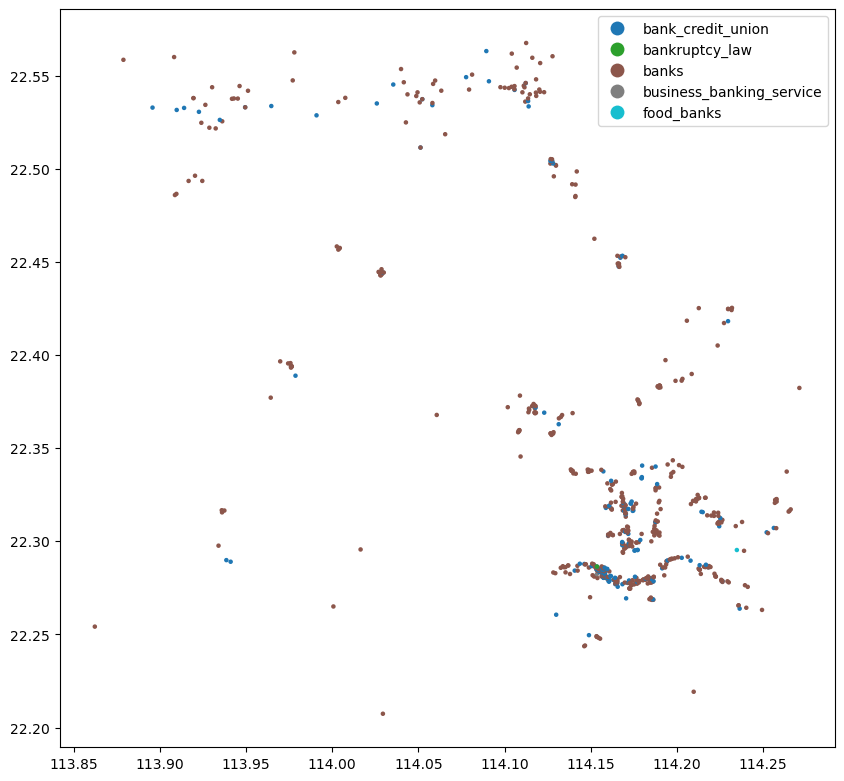

In [23]:
filtered_df[filtered_df['top_category'].str.contains('bank')].plot(column = "top_category", legend=True, figsize=(10,10), markersize=5)

<Axes: >

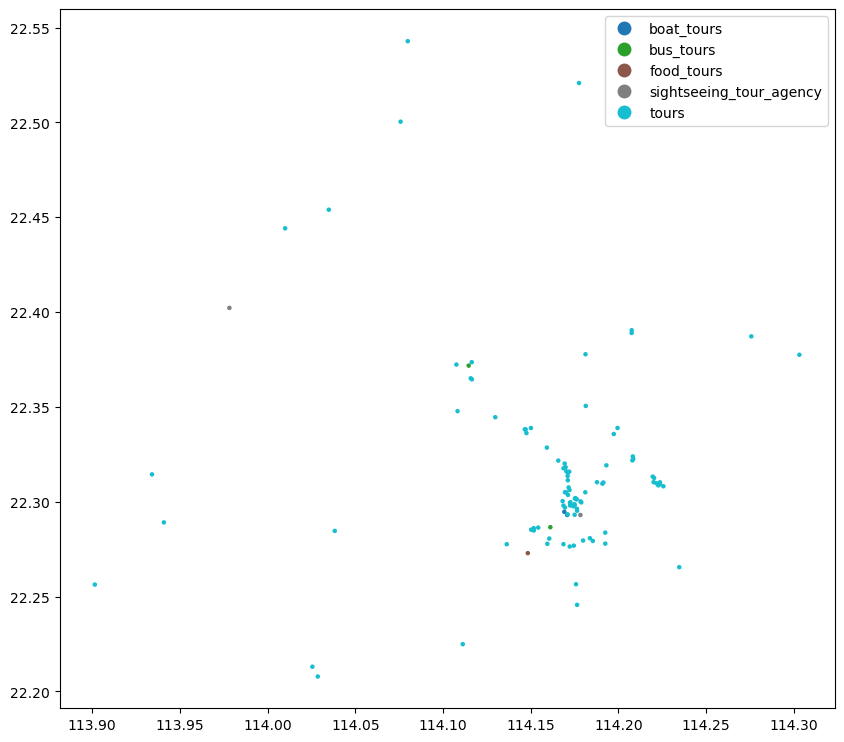

In [ ]:
filtered_df[filtered_df['top_category'].str.contains('tour')]\
    .plot(column = "top_category", legend=True, figsize=(10,10), markersize=5)

In [4]:
df_hk = fetcher.fetch_pois_by_polygon(boundary_gdf.geometry.unary_union)
df_hk.head()

Fetching POIs from Overture Maps (global dataset)...
Error fetching POIs: IO Error: No files found that match the pattern "s3://overturemaps-us-west-2/release/2024-10-23.0/theme=places/type=place/*"


""


In [ ]:
def main():
    """Example usage of the POI fetcher"""
    
    # Initialize fetcher
    fetcher = OverturePOIFetcher()
    
    # Example 1: Fetch POIs by city name
    print("=" * 50)
    print("Example 1: Fetching POIs for San Francisco, CA, USA")
    print("=" * 50)
    
    df_sf = fetcher.fetch_pois_by_city(
        city_name="San Francisco",
        state="California",
        country="USA"
    )
    
    if not df_sf.empty:
        print(f"\nFirst 10 POIs:")
        print(df_sf[['place_name', 'place_type', 'latitude', 'longitude']].head(10))
        
        # Save to file
        fetcher.save_to_file(df_sf, "san_francisco_pois.csv")
    
    # Example 2: Fetch POIs by polygon (Times Square area, NYC)
    print("\n" + "=" * 50)
    print("Example 2: Fetching POIs for Times Square area (polygon)")
    print("=" * 50)
    
    # Define a polygon around Times Square, NYC
    times_square_polygon = Polygon([
        (-73.991, 40.754),  # Southwest
        (-73.983, 40.754),  # Southeast
        (-73.983, 40.762),  # Northeast
        (-73.991, 40.762),  # Northwest
        (-73.991, 40.754)   # Close polygon
    ])
    
    df_ts = fetcher.fetch_pois_by_polygon(times_square_polygon)
    
    if not df_ts.empty:
        print(f"\nFirst 10 POIs in Times Square area:")
        print(df_ts[['place_name', 'place_type', 'latitude', 'longitude']].head(10))
        
        # Save to file
        fetcher.save_to_file(df_ts, "times_square_pois.csv")
    
    # Close connection
    fetcher.close()
    
    print("\n" + "=" * 50)
    print("POI fetching complete!")
    print("=" * 50)


if __name__ == "__main__":
    main()

In [46]:
# stage 2 classify poi
import h3
import os
import pandas as pd
import geopandas as gpd
import duckdb as dk

CBD_KEYWORDS = ["bank", "mall", "finance", "business", "office", "commercial"]
TOURISM_KEYWORDS = [
    "museum",
    "tour",
    "tourist_info",
    "attraction",
    "gallery",
    "amusement_park",
    "theme_park",
    "souvenir",
    "cultural",
    "historical",
    "temple",
    "overlook",
    "viewpoint",
]
RESIDENTIAL_KEYWORDS = ["school", "library", "kindergarten", "college", "hospital"]
INDUSTRIAL_KEYWORDS = ["industrial", "factory", "warehouse"]


def classify_poi(places_df: pd.DataFrame) -> pd.DataFrame:
    places_df["top_category"] = places_df["categories"].apply(
        lambda x: x["primary"] if isinstance(x, dict) and "primary" in x else "unknown"
    )

    def classify_row(cat: str) -> str:
        cat_lower = cat.lower()
        if any(keyword in cat_lower for keyword in CBD_KEYWORDS):
            return "cbd"
        elif any(keyword in cat_lower for keyword in TOURISM_KEYWORDS):
            return "tourism"
        elif any(keyword in cat_lower for keyword in RESIDENTIAL_KEYWORDS):
            return "residential"
        elif any(keyword in cat_lower for keyword in INDUSTRIAL_KEYWORDS):
            return "industrial"
        else:
            return "other"

    places_df["landuse_type"] = places_df["top_category"].apply(classify_row)
    return places_df

In [36]:
input_folder = (
        "/Users/yuan/Dropbox (Personal)/Personal Work/_commondata/POI/overtunemaps/raw"
    )
output_folder = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2025/urban-sim-flow/_data/_transformed/landuse"

cityls = os.listdir(input_folder)
valid_cityls = [x for x in cityls if x.endswith(".parquet")]
cityls = [x.replace(".parquet", "") for x in valid_cityls]
city_name = "Hong Kong"
city_lower = city_name.lower().replace(" ", "")
file_path = os.path.join(input_folder, f"{city_lower}.parquet")
places_df = gpd.read_parquet(file_path)

In [47]:
classified_places_df = classify_poi(places_df)

In [48]:
for res in [7, 8, 9]:
    classified_places_df[f"h3_res{res}"] = classified_places_df.apply(
        lambda row: h3.latlng_to_cell(row["geometry"].y, row["geometry"].x, res),
        axis=1,
    )

# explode the dataframe to have one row per h3 index
records = []
for _, row in classified_places_df.iterrows():
    for res in [7, 8, 9]:
        records.append(
            {
                "h3_index": row[f"h3_res{res}"],
                "landuse_type": row["landuse_type"],
                "resolution": res,
            }
        )
h3_df = pd.DataFrame(records)

In [52]:
result_df1 = dk.query(
    """WITH aggregated AS (
        SELECT 
            h3_index, 
            landuse_type, 
            resolution,
            COUNT(*) as count
        FROM h3_df
        WHERE landuse_type <> 'other'
        GROUP BY resolution, h3_index, landuse_type
        ),
    ranked_by_type AS (
        SELECT 
            resolution, 
            h3_index, 
            count,
            RANK() OVER (PARTITION BY resolution ORDER BY count DESC) as type_rank,
            'cbd' as landuse_type
        FROM aggregated
        WHERE landuse_type = 'cbd'
        UNION ALL
        SELECT 
            resolution, 
            h3_index, 
            count,
            RANK() OVER (PARTITION BY resolution ORDER BY count DESC) as type_rank,
            'tourism' as landuse_type
        FROM aggregated
        WHERE landuse_type = 'tourism'
        UNION ALL
        SELECT 
            resolution, 
            h3_index, 
            count,
            RANK() OVER (PARTITION BY resolution ORDER BY count DESC) as type_rank,
            'residential' as landuse_type
        FROM aggregated
        WHERE landuse_type = 'residential'
        UNION ALL
        SELECT 
            resolution, 
            h3_index, 
            count,
            RANK() OVER (PARTITION BY resolution ORDER BY count DESC) as type_rank,
            'industrial' as landuse_type
        FROM aggregated
        WHERE landuse_type = 'industrial'
        ),
        -- select the landuse_type with the highest rank (lowest type_rank) for each h3_index
        final_classification AS (
        SELECT 
            resolution, 
            h3_index, 
            MIN(type_rank) as rank
        FROM ranked_by_type
        GROUP BY resolution, h3_index
        ),
        selected AS (
        SELECT 
            f.resolution,
            f.h3_index,
            r.landuse_type
        FROM final_classification f
        JOIN ranked_by_type r
            ON f.h3_index = r.h3_index 
            AND f.resolution = r.resolution
            AND f.rank = r.type_rank
            )
        -- if the rank of two landuses types are the same, put the landuse_types into one array
        SELECT
            s.resolution,
            s.h3_index,
            CASE 
                WHEN COUNT(*) > 1 THEN array_to_string(ARRAY_AGG(s.landuse_type), ', ')
                ELSE MAX(s.landuse_type)
            END as landuse_type
        FROM selected s
        GROUP BY s.resolution, s.h3_index
        """
).to_df()
result_df1.head()

,resolution,h3_index,landuse_type
0,8,88411caa07fffff,residential
1,8,88411cb9b7fffff,residential
2,8,88411cb891fffff,residential
3,8,88411caa1bfffff,residential
4,8,8841034823fffff,residential


In [55]:
result_df1[result_df1['resolution'] == 7].to_parquet(
    path=os.path.join(output_folder, f"{city_lower}_landuse_res7.parquet"),
    index = False
)

In [53]:
result_df1.groupby('landuse_type').size()

landuse_type
cbd                         647
industrial                  257
industrial, cbd               2
industrial, tourism           2
residential                1083
residential, cbd              4
residential, industrial       1
residential, tourism          5
tourism                    1968
tourism, cbd                  3
dtype: int64

In [ ]:
def classify_h3_index(places_df: pd.DataFrame) -> pd.DataFrame:
    # create h3 index at resolution 7,8,9
    for res in [7, 8, 9]:
        places_df[f"h3_res{res}"] = places_df.apply(
            lambda row: h3.latlng_to_cell(row["geometry"].y, row["geometry"].x, res),
            axis=1,
        )

    # explode the dataframe to have one row per h3 index
    records = []
    for _, row in places_df.iterrows():
        for res in [7, 8, 9]:
            records.append(
                {
                    "h3_index": row[f"h3_res{res}"],
                    "landuse_type": row["landuse_type"],
                    "resolution": res,
                }
            )
    h3_df = pd.DataFrame(records)

    # aggregate to get the dominant landuse type per h3 index
    # for each h3_index, get its rank based on count of each type of landuse_type
    # for example, if an h3_index ranked 1 for 'cbd', 2 for 'tourism', then we classify it as 'cbd'
    resultdf = dk.query(
        """
            WITH aggregated AS (
        SELECT 
            h3_index, 
            landuse_type, 
            resolution,
            COUNT(*) as count
        FROM h3_df
        WHERE landuse_type <> 'other'
        GROUP BY resolution, h3_index, landuse_type
        ),
        ranked_by_type AS (
        SELECT 
            resolution, 
            h3_index, 
            RANK() OVER (PARTITION BY resolution, h3_index ORDER BY count DESC) as type_rank,
            'cbd' as landuse_type
        FROM aggregated
        WHERE landuse_type = 'cbd'
        UNION ALL
        SELECT 
            resolution, 
            h3_index, 
            RANK() OVER (PARTITION BY resolution, h3_index ORDER BY count DESC) as type_rank,
            'tourism' as landuse_type
        FROM aggregated
        WHERE landuse_type = 'tourism'
        UNION ALL
        SELECT 
            resolution, 
            h3_index, 
            RANK() OVER (PARTITION BY resolution, h3_index ORDER BY count DESC) as type_rank,
            'residential' as landuse_type
        FROM aggregated
        WHERE landuse_type = 'residential'
        UNION ALL
        SELECT 
            resolution, 
            h3_index, 
            RANK() OVER (PARTITION BY resolution, h3_index ORDER BY count DESC) as type_rank,
            'industrial' as landuse_type
        FROM aggregated
        WHERE landuse_type = 'industrial'
        ),
        -- select the landuse_type with the highest rank (lowest type_rank) for each h3_index
        final_classification AS (
        SELECT 
            resolution, 
            h3_index, 
            MIN(type_rank) as rank
        FROM ranked_by_type
        GROUP BY resolution, h3_index
        )
        SELECT 
            f.resolution,
            f.h3_index,
            r.landuse_type
        FROM final_classification f
        JOIN ranked_by_type r
            ON f.h3_index = r.h3_index 
            AND f.resolution = r.resolution
            AND f.rank = r.type_rank
        """
    ).to_df()

    return resultdf

#